<a href="https://colab.research.google.com/github/Kvnhooman/AAI521_Computer_vision_Group-4/blob/Kevin_Dev/Final_Project_Kevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from collections import Counter


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
!rm -rf "/content/drive/MyDrive/AAI521-Final Project/data/food101"   # remove any old corrupted folder
!mkdir -p "/content/drive/MyDrive/AAI521-Final Project/data/food101"
%cd "/content/drive/MyDrive/AAI521-Final Project/data/food101"


/content/drive/MyDrive/AAI521-Final Project/data/food101


If running this notebook for the first time, uncomment the below cells.


In [4]:
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz


--2025-11-23 23:18:37--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-11-23 23:18:37--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  16.3MB/s    in 5m 8s   

2025-11-23 23:23:47 (15.5 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [5]:
#!tar -xvf food-101.tar.gz


Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [6]:
root = pathlib.Path("/content/drive/MyDrive/AAI521-Final Project/data/food101/food-101")

images_dir = root / "images"
meta_dir   = root / "meta"

print("Images dir exists:", images_dir.exists())
print("Meta dir exists:", meta_dir.exists())


Images dir exists: True
Meta dir exists: True


In [7]:
# Remove macOS junk if any exists
class_names = sorted([
    d.name for d in images_dir.iterdir()
    if d.is_dir() and not d.name.startswith("._")
])

class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Number of classes:", len(class_names))
print("Example classes:", class_names[:10])


Number of classes: 101
Example classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [8]:
def read_list(p: pathlib.Path):
    with open(p, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

train_list = read_list(meta_dir / "train.txt")
test_list  = read_list(meta_dir / "test.txt")
train_list = [s for s in train_list if not s.startswith("._")]
test_list  = [s for s in test_list if not s.startswith("._")]


In [9]:
def to_path_and_label(stem: str):
    cls, base = stem.split("/", 1)
    return str(images_dir / cls / f"{base}.jpg"), class_to_idx[cls]

train_pairs = [to_path_and_label(s) for s in train_list]
test_pairs  = [to_path_and_label(s) for s in test_list]


This shows our original dataset has inconsistent image sizes. Therefore, resizing to a fixed shape is necessary since our deep learning models require for the input to have uniform dimensions.

In [10]:
augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])


In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 0

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = augment(img, training=True)
    img = preprocess_input(img)
    return img, label


In [12]:
train_paths, train_labels = zip(*train_pairs)
test_paths, test_labels   = zip(*test_pairs)

train_ds = (
    tf.data.Dataset
        .from_tensor_slices((list(train_paths), list(train_labels)))
        .shuffle(len(train_pairs), seed=SEED, reshuffle_each_iteration=True)
        .map(decode_resize, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset
        .from_tensor_slices((list(test_paths), list(test_labels)))
        .map(decode_resize, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
)

xb, yb = next(iter(train_ds.take(1)))
print("Batch:", xb.shape, xb.dtype)
print("Pixel range after preprocess_input:", float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))


Batch: (32, 224, 224, 3) <dtype: 'float32'>
Pixel range after preprocess_input: -1.0 1.0


Visualize sample images

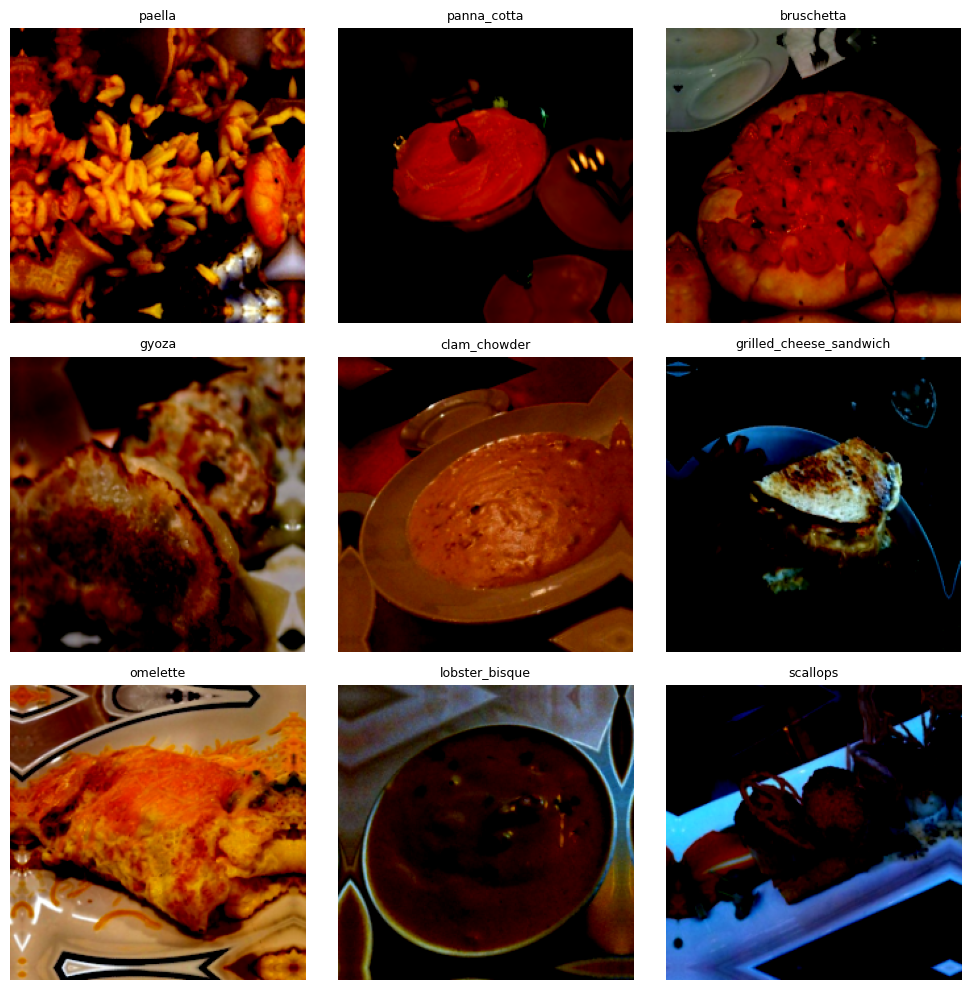

In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i].numpy())], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


Count Training and testing split sizes

In [14]:
print("Training examples:", len(train_list))
print("Testing examples:", len(test_list))
print("Classes:", len(class_names))
print("Image shape after preprocessing:", xb[0].shape)


Training examples: 75750
Testing examples: 25250
Classes: 101
Image shape after preprocessing: (224, 224, 3)


Bar Plot for distribution classes

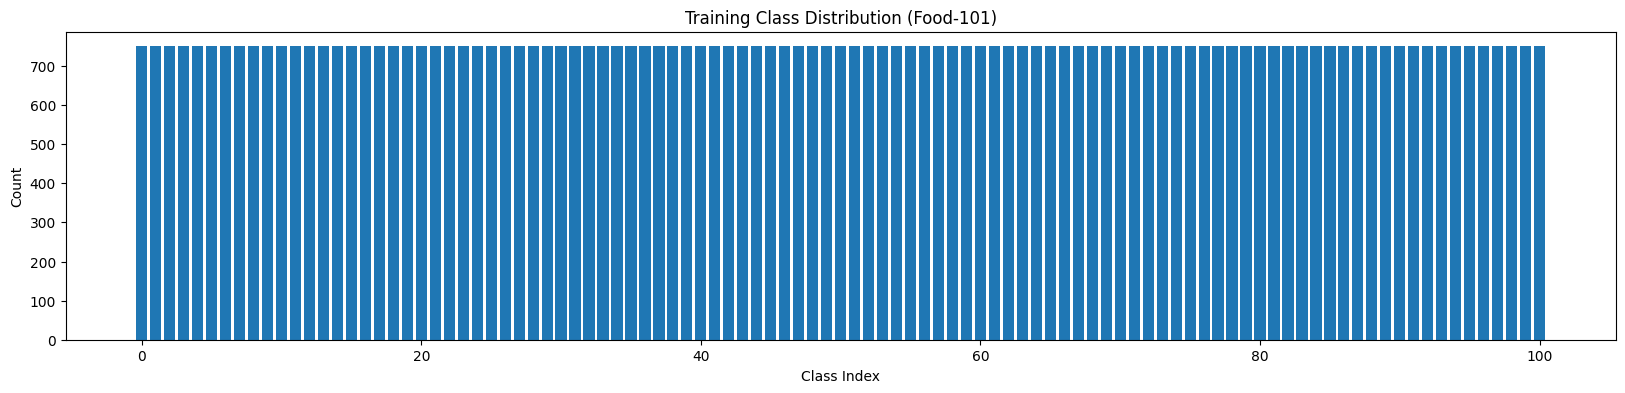

In [15]:
train_classes = [s.split("/")[0] for s in train_list]
train_counts = Counter(train_classes)

plt.figure(figsize=(20,4))
plt.bar(range(len(train_counts)), train_counts.values())
plt.title("Training Class Distribution (Food-101)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()


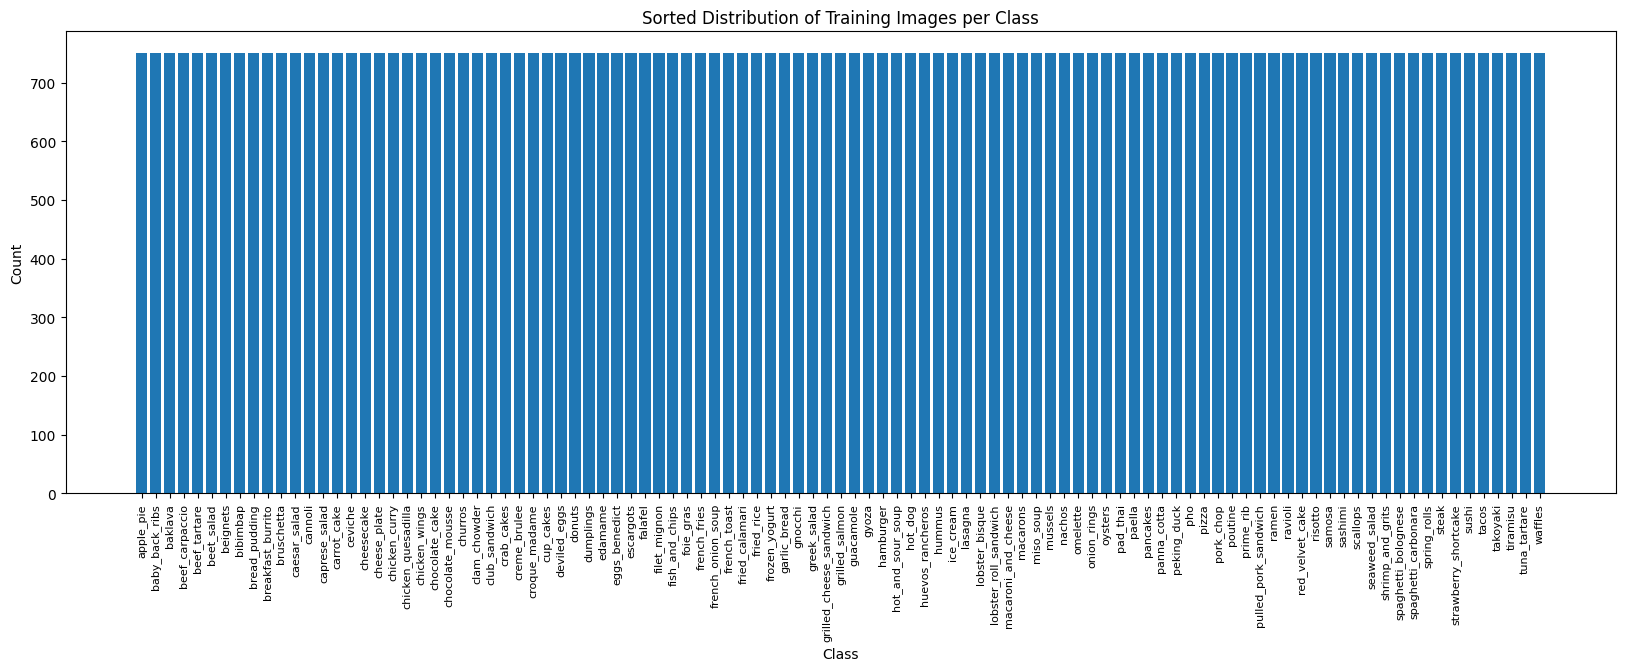

Average images per class: 750.0


In [21]:
train_classes = [s.split("/")[0] for s in train_list]
train_counts = Counter(train_classes)

sorted_counts = dict(sorted(train_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(20,6))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90, fontsize=8)
plt.title("Sorted Distribution of Training Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Average images per class:", sum(sorted_counts.values())/len(sorted_counts))


Data is well balanced among different classes.

In [16]:
sizes = []

sample_classes = class_names[:10]  #sample 10 classes
for cls in sample_classes:
    img_files = os.listdir(images_dir / cls)[:20]
    for img_name in img_files:
        img_path = images_dir / cls / img_name
        img = cv2.imread(str(img_path))
        if img is not None:
            sizes.append(img.shape[:2])  #(height, width)

sizes = np.array(sizes)

print("Min size:", sizes.min(axis=0))
print("Max size:", sizes.max(axis=0))
print("Mean size:", sizes.mean(axis=0))


Min size: [288 288]
Max size: [512 512]
Mean size: [474.065 502.62 ]


Checking for any corrupted files before training:

In [22]:
bad_images = []

for cls in class_names[:20]:  # scan only 20 classes
    for img_name in os.listdir(images_dir / cls):
        if img_name.startswith("._"):
            continue
        img_path = images_dir / cls / img_name
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            bad_images.append(img_path)

print("Corrupted images found:", len(bad_images))
if len(bad_images) > 0:
    print(bad_images[:10])


Corrupted images found: 0


Defining the Baseline CNN Model


In [23]:
# Baseline CNN model (very simple)
baseline_model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,270,629 (84.96 MB)

 Trainable params: 22,270,629 (84.96 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model:

In [24]:
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=4
)


Epoch 1/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 285s 116ms/step - accuracy: 0.0319 - loss: 4.4946 - val_accuracy: 0.1101 - val_loss: 3.8941
Epoch 2/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 110ms/step - accuracy: 0.1123 - loss: 3.8891 - val_accuracy: 0.1682 - val_loss: 3.5015
Epoch 3/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 111ms/step - accuracy: 0.1704 - loss: 3.5336 - val_accuracy: 0.2103 - val_loss: 3.2684
Epoch 4/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 110ms/step - accuracy: 0.2113 - loss: 3.3092 - val_accuracy: 0.2410 - val_loss: 3.1478


Loss & Accuracy Curves

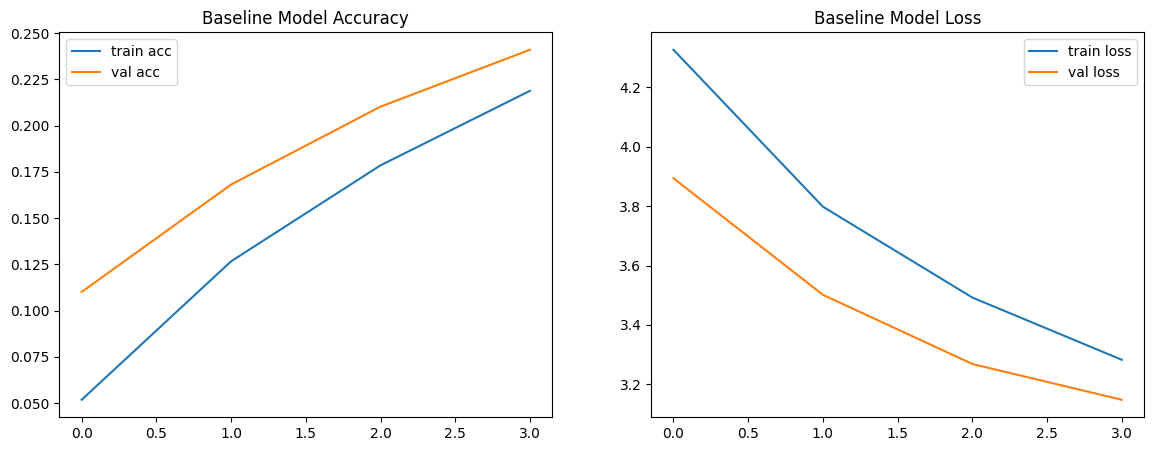

In [25]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_baseline.history['accuracy'], label='train acc')
plt.plot(history_baseline.history['val_accuracy'], label='val acc')
plt.title("Baseline Model Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_baseline.history['loss'], label='train loss')
plt.plot(history_baseline.history['val_loss'], label='val loss')
plt.title("Baseline Model Loss")
plt.legend()

plt.show()


Model Evaluation

In [26]:
baseline_eval = baseline_model.evaluate(test_ds)
print("Baseline Test Loss:", baseline_eval[0])
print("Baseline Test Accuracy:", baseline_eval[1])


790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.2442 - loss: 3.1261
Baseline Test Loss: 3.140556812286377
Baseline Test Accuracy: 0.24372276663780212


To improve model accuracy significantly compared to the baseline CNN, we use a pre-trained MobileNetV2 model (trained on ImageNet).
We freeze the convolutional base to keep the learned feature extractor and train only a new classifier head on the Food-101 dataset.

### Transfer Learning

In [28]:
# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze pretrained layers
base_model.trainable = False

base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
# Build the transfer learning model
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)   # prevent overfitting
outputs = keras.layers.Dense(len(class_names), activation="softmax")(x)

tl_model = keras.Model(inputs, outputs)

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# Build the transfer learning model
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)   # prevent overfitting
outputs = keras.layers.Dense(len(class_names), activation="softmax")(x)

tl_model = keras.Model(inputs, outputs)

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
history_tl = tl_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6
)


Epoch 1/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 329s 128ms/step - accuracy: 0.1330 - loss: 4.0098 - val_accuracy: 0.4499 - val_loss: 2.3642
Epoch 2/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 264s 111ms/step - accuracy: 0.4043 - loss: 2.4796 - val_accuracy: 0.5178 - val_loss: 1.9640
Epoch 3/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 264s 111ms/step - accuracy: 0.4675 - loss: 2.1691 - val_accuracy: 0.5435 - val_loss: 1.8161
Epoch 4/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 112ms/step - accuracy: 0.4888 - loss: 2.0611 - val_accuracy: 0.5611 - val_loss: 1.7335
Epoch 5/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 264s 111ms/step - accuracy: 0.5107 - loss: 1.9589 - val_accuracy: 0.5705 - val_loss: 1.6835
Epoch 6/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 264s 111ms/step - accuracy: 0.5177 - loss: 1.9114 - val_accuracy: 0.5825 - val_loss: 1.6383


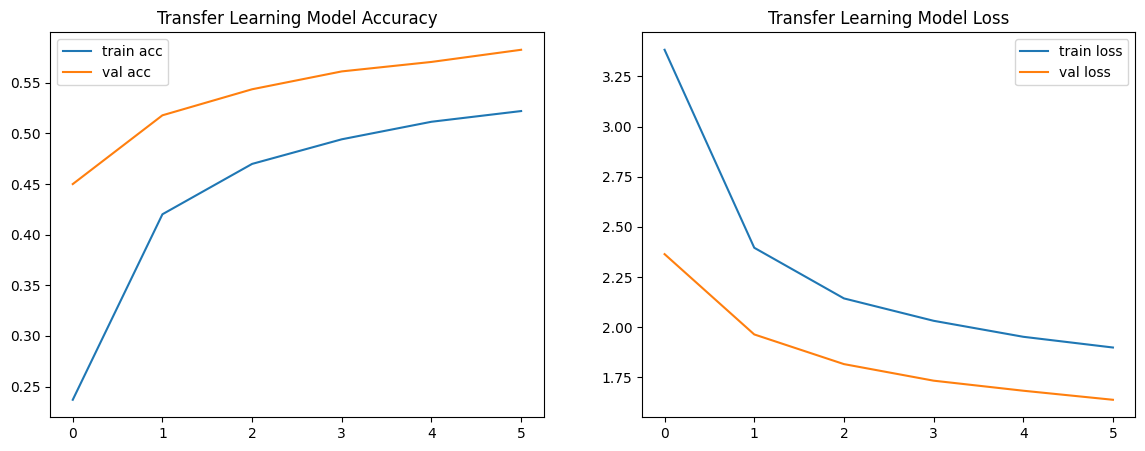

In [32]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_tl.history['accuracy'], label='train acc')
plt.plot(history_tl.history['val_accuracy'], label='val acc')
plt.title("Transfer Learning Model Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_tl.history['loss'], label='train loss')
plt.plot(history_tl.history['val_loss'], label='val loss')
plt.title("Transfer Learning Model Loss")
plt.legend()

plt.show()


In [33]:
tl_eval = tl_model.evaluate(test_ds)
print("TL Test Loss:", tl_eval[0])
print("TL Test Accuracy:", tl_eval[1])


790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.5554 - loss: 1.7340
TL Test Loss: 1.639531135559082
TL Test Accuracy: 0.5780594348907471


Save the trained Model

In [34]:
# Save the trained transfer learning model
save_path = "/content/drive/MyDrive/AAI521-Final Project/models/tl_food101_model.h5"

# Create folder
os.makedirs(os.path.dirname(save_path), exist_ok=True)

tl_model.save(save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/AAI521-Final Project/models/tl_food101_model.h5


Save the training history:

In [35]:
import pickle

history_path = "/content/drive/MyDrive/AAI521-Final Project/models/tl_history.pkl"

with open(history_path, "wb") as f:
    pickle.dump(history_tl.history, f)

print("Training history saved.")


Training history saved.
